# Metadata

```yaml
Course:    DS 5001
Module:    M12 Lab
Topic:     Implementing Naive Bayes in SciKit Learn
Author:    R.C. Alvarado
Date:      19 April 2023
```

# Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f'{data_home}/{data_prefix}/{data_prefix}'
class Params:
    test_size = 0.25

# Import

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.naive_bayes import MultinomialNB

# Get Data

We import our split data.

In [61]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [72]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Apply Model

In [66]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

# Evaluate model

In [67]:
clf.score(X_test, y_test)

0.798875

In [7]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [8]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

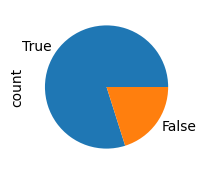

In [9]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

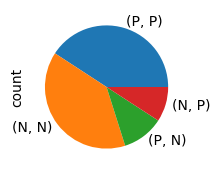

In [10]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

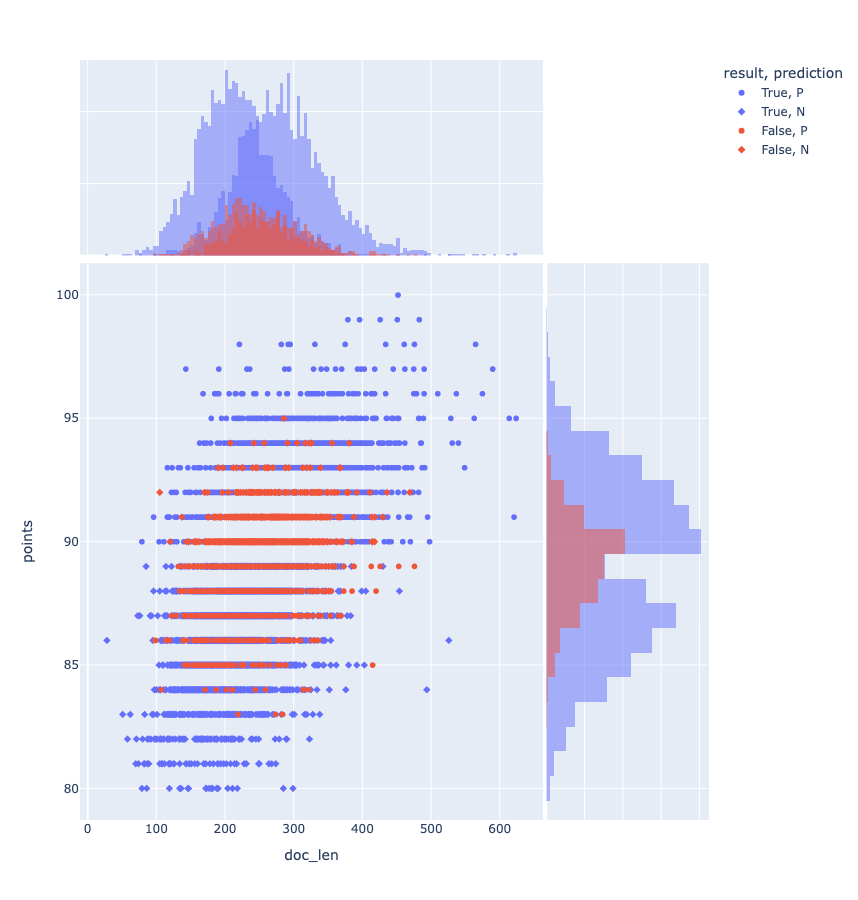

In [75]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [33]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [34]:
CM

doc_label,N,P
prediction,,
N,3127,733
P,876,3264


In [35]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'

    R['TP'] = CM.iloc[0,0]   # hits
    R['FP'] = CM.iloc[0,1]   # Type I errors or false alarms
    R['TN'] = CM.iloc[1,1]   # correct rejections
    R['FN'] = CM.iloc[1,0]   # Type II errors or misses
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [36]:
R = get_results(CM, 'skmnb')

In [37]:
R.T.style.format(precision=2)

model_id,skmnb
TP,3127.00
FP,733.00
TN,3264.00
FN,876.00
T,6391.00
F,1609.00
ALL,8000.00
ACC,0.80
TPR,0.78
TNR,0.82


# Extract Sentiment

In [18]:
FLP = pd.DataFrame(clf.feature_log_prob_).T
FLP.columns = clf.classes_
FLP.index = X_train.columns

In [19]:
SALEX = (FLP.P - FLP.N).to_frame('valence')

In [20]:
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])
SALEX = SALEX.sort_values('valence')

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [23]:
SALEX.sort_values('valence', ascending=False).head(20)

,valence,polarity,normalized
term_str,,,
91,4.020884,1.0,1.000000
exquisite,3.866734,1.0,0.962895
2035,3.533589,1.0,0.882706
dazzling,3.510059,1.0,0.877042
impeccable,3.461269,1.0,0.865298
2027,3.448690,1.0,0.862270
2030,3.435951,1.0,0.859204
2028,3.401165,1.0,0.850831
92,3.369701,1.0,0.843257


In [24]:
SALEX.sort_values('valence', ascending=True).head(20)

,valence,polarity,normalized
term_str,,,
watery,-4.288054,-1.0,-1.000000
dilute,-4.077758,-1.0,-0.949381
melony,-4.011800,-1.0,-0.933505
mealy,-3.941183,-1.0,-0.916507
weedy,-3.838529,-1.0,-0.891797
diluted,-3.811130,-1.0,-0.885202
scouring,-3.753971,-1.0,-0.871444
informal,-3.724118,-1.0,-0.864258
generic,-3.724118,-1.0,-0.864258


**Ratio of positive to negative terms**

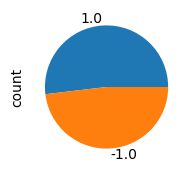

In [25]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

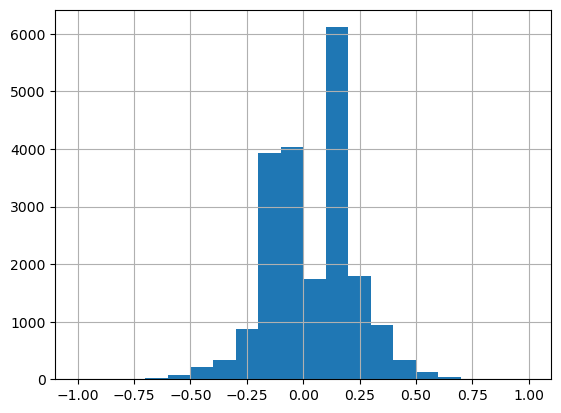

In [26]:
SALEX.normalized.hist(bins=20);

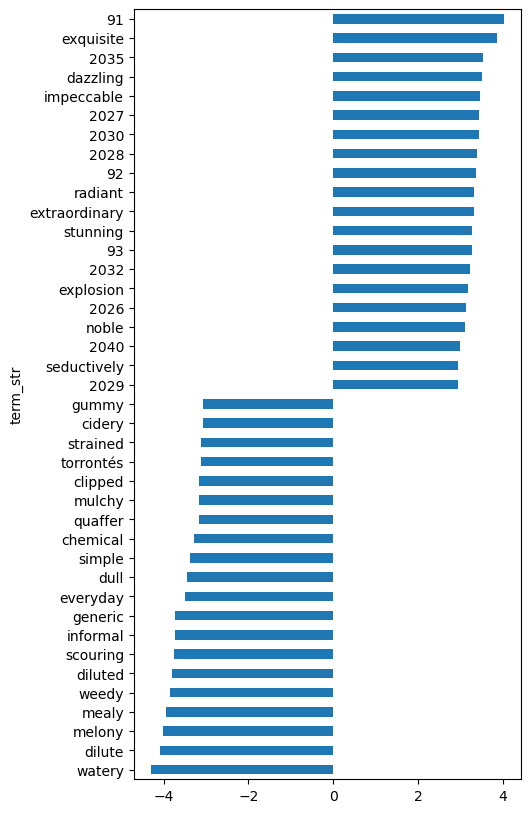

In [27]:
pd.concat([SALEX.valence.head(20),SALEX.valence.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [28]:
SALEX.to_csv(f"{data_path}-SKMNB_SALEX.csv")
R.to_csv(f"{data_path}-SKMNB_RESULT.csv", index=True)